In [1]:
import yfinance as yf
import numpy as np
import scipy.stats as stats
import pandas as pd
import cvxpy as cp
import datetime
import matplotlib.pyplot as plt

In [2]:
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "TSLA", "AVGO", "BRK-B", "WMT",
    "LLY", "JPM", "V", "MA", "UNH", "ORCL", "XOM", "TSM", "JNJ", "PG",
    "HD", "CVX", "KO", "PEP", "BAC", "MRK", "ABBV", "PFE", "CSCO", "ADBE",
    "NFLX", "NKE", "VZ", "INTC", "T", "CMCSA", "CRM", "ABT", "MCD", "DIS",
    "BABA", "TM", "SHEL", "NVS", "ASML", "AZN", "SNY", "LIN", "PM", "ACN",
    "TMO", "DHR", "COST", "WFC", "MS", "UPS", "BMY", "TXN", "NEE", "QCOM",
    "AMGN", "UL", "SAP", "UNP", "MDT", "HON", "INTU", "LOW", "SCHW",
    "RTX", "AMT", "SPGI", "GS", "BLK", "IBM", "PLD", "CVS", "DE", "SBUX",
    "BA", "CAT", "ELV", "NOW", "PYPL", "SHOP", "SONY", "MUFG", "HDB", "TD",
    "BP", "RIO", "OR", "ENB", "EQNR", "SREN.SW", "ZURN.SW", "ROG.SW", "GIVN.SW",
    "ADEN.SW", "NESN.SW", "UHR.SW", "CFR.SW", "RACE", "MBG.DE",
    "AIR.PA", "BAYN.DE", "BMW.DE", "DTE.DE", "DBK.DE", "SAN.PA", "OR.PA",
    "MC.PA", "BNP.PA", "SU.PA", "DG.PA", "ENGI.PA", "VIV.PA", "BARC.L",
    "LLOY.L", "GSK.L", "TSCO.L", "HSX.L", "VALE", "PBR", "BBDC4.SA", "ITUB4.SA",
    "WEGE3.SA", "ABEV", "BRFS3.SA", "MELI", "YPF", "ORSTED.CO",
    "NOVO-B.CO", "DSV.CO", "VWS.CO", "VOLV-B.ST", "ERIC-B.ST",
    "EQT", "DDOG", "SNOW", "PLTR", "TWLO", "SE", "BIDU",
    "NTES", "JD", "PDD", "XPEV", "NIO", "LI", "STLA", "MTX.DE",
    "SAP.DE", "VOW3.DE", "RWE.DE", "HEN3.DE", "IFX.DE", "BYDDY", "TCEHY", "NOK",
    "SPY", "VT", "GLD", "XLF", "XLV", "XLE", "QQQ", "IONQ", "XPH", "FSLR", "ENPH",
    "VWDRY", "CSIQ", "GXC", "CQQQ"
]
tickers = sorted(tickers)

# Dictionary to store ticker-currency mappings
ticker_currencies = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    currency = stock.info.get("currency", None)  # Retrieve currency info
    ticker_currencies[ticker] = currency.upper()
    
currency_set = set(ticker_currencies.values())
currency_set.discard("CHF")
currency_tickers = ["CHF" + currency + "=X" for currency in currency_set]

The tickers are international, so we have to be careful to convert prices to CHF before computing returns. We can grab the currencies straight from `yfinance`.

The `data` variable stores the prices for every two days (we skip a day to reduce noise in the currency exchange and closing time differences between markets). The `returns` variable gives the percent change over 2 days. The currency exchanges are removed from `returns`.

In [3]:
print("Downloading historical data...")
n_years = 5
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(days=n_years*365)
data = yf.download(tickers + currency_tickers, start=start_date, end=end_date, interval="1d", progress=False)
data = data["Close"].dropna(how="all").ffill().dropna()
data = data.iloc[::-2].iloc[::-1]
for ticker in tickers:
    currency = ticker_currencies[ticker]
    if currency != "CHF":
        data[ticker] /= data["CHF" + currency + "=X"].values
returns = np.log(data.drop(currency_tickers, axis=1)).diff().dropna()
print("Got the historical data!")
returns.head()

Got the historical data!


Ticker,AAPL,ABBV,ABEV,ABT,ACN,ADBE,ADEN.SW,AIR.PA,AMGN,AMT,...,WFC,WMT,XLE,XLF,XLV,XOM,XPEV,XPH,YPF,ZURN.SW
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-06,-0.027540,-0.003975,0.020817,0.004626,0.010964,-0.045586,0.014432,0.001564,0.023073,-0.027268,...,0.090335,-0.004700,0.068276,0.042089,0.015266,0.066678,-0.072880,0.005380,0.022768,0.026858
2021-01-08,0.050054,0.023786,0.007906,0.020347,0.020937,0.047410,0.005317,0.004615,0.030122,0.041357,...,0.023085,0.007701,0.021273,0.021582,0.025610,0.026780,0.105352,0.029110,0.016471,-0.001300
2021-01-12,-0.019882,0.028167,0.043381,-0.020094,-0.017009,-0.023081,-0.004651,-0.005383,-0.002961,-0.028321,...,0.027383,0.020870,0.054953,0.018529,-0.001201,0.056902,0.182949,0.017511,-0.110084,-0.006001
2021-01-14,-0.002209,0.025277,-0.001320,0.011923,-0.012896,-0.020989,0.001331,0.033160,0.018141,-0.002690,...,0.020523,-0.016579,0.018298,0.000760,-0.003491,0.046444,-0.079383,-0.004173,-0.010265,-0.010259
2021-01-18,-0.007890,-0.004058,-0.035804,0.017321,0.000628,-0.005330,-0.009020,-0.023377,0.021660,0.028472,...,-0.075259,-0.010045,-0.033735,-0.010731,0.009018,-0.043361,-0.044824,0.000363,-0.040929,-0.007964


Here we create the `stock_info` variable, which contains `dividends` and `marketCap` data for each stock in the portfolio.

In [4]:
def get_stock_info(ticker):
    stock_info = {"dividends" : 0}
    ticker_info = yf.Ticker(ticker).info

    # get dividends
    dividend_keys = ("yield", "dividendYield")
    for key in dividend_keys:
        if key in ticker_info.keys():
            stock_info["dividends"] = ticker_info[key]
            break
    
    # get marketCap
    currency = ticker_currencies[ticker]
    if currency == "CHF":
        conversion = 1
    else:
        conversion = data["CHF" + currency + "=X"].iloc[-1]
    cap_keys = ("marketCap", "totalAssets")
    for key in cap_keys:
        if key in ticker_info.keys():
            stock_info["marketCap"] = ticker_info[key] / conversion
            break
    if "marketCap" not in stock_info.keys():
        stock_info["marketCap"] = None
    
    return stock_info

print("Getting dividends and market cap...")
stock_info = pd.DataFrame([get_stock_info(ticker) for ticker in tickers], index=tickers)
print("Got the stock info!")

Getting dividends and market cap...
Got the stock info!


### Covariance calculation

Here, we use two techniques to calculate the covariance matrix.
- We weight more recent observations in `returns` more than the older ones when computing the basic covariance matrix
- Then, we use Ledoit-Wolf shrinkage to correct for overfitting. The target covariance matrix uses uniform correlation between all the stocks.

In [5]:
time_span = returns.index[-1] - returns.index[0]
n_years = time_span.days / 365
entries_per_year = len(returns) / n_years

# Calculate the covariance matrix based on weights that decrease exponentially with time
lamb = (1/n_years)**(1/n_years) # lambda in the exponential time weighting
weights = lamb**(np.array([(end_date - day).days for day in returns.index]) / 365)
weights /= np.sum(weights)
weighted_mean = (returns * weights[:, None]).sum()
weighted_cov = ((returns - weighted_mean) * weights[:, None]).T @ (returns - weighted_mean)
weighted_cov *= entries_per_year

# Estimate the correlation for Ledoit-Wolf shrinkage
delta = 0.2 # larger --> more shrinkage
standard_devs = np.sqrt(np.diag(weighted_cov))
weighted_corr = weighted_cov / standard_devs[None, :] / standard_devs[:, None]
average_corr = (np.sum(weighted_corr.values) - len(weighted_corr)) / len(weighted_corr) / (len(weighted_corr) - 1)
target_cov = np.full(weighted_cov.shape, average_corr)
np.fill_diagonal(target_cov, 1)
target_cov = pd.DataFrame(target_cov, index=weighted_cov.index, columns=weighted_cov.index)
target_cov = target_cov * standard_devs[None, :] * standard_devs[:, None]
sigma = delta * target_cov + (1 - delta) * weighted_cov # this is the empirical Sigma in the BL formulation

### Returns calculation

Our main tool will be the Black-Litterman model. Here, we assume that the market caps are weights used by the global economy, and we can calculate the expected returns by passing these weights through `sigma`.

From these expected returns, we update them based on our `views`.

The final adjusted `expected_returns` will be used to optimize our portfolio by conditioning on a minimum total expected return.

In [8]:
# Market return
risk_aversion = 3.5 # higher means that investors require higher returns for a single unit of risk
pi = risk_aversion * sigma @ stock_info["marketCap"] / stock_info["marketCap"].sum() # exess returns (after risk free + dividends)
oil_gas_tickers = ["BP", "CVX", "ENB", "EQNR", "PBR", "RIO", "SHEL", "VALE", "XOM", "XLE"]

one_hot = pd.DataFrame(np.eye(len(pi)), columns=pi.index) # Creates a a one-hot vector corresponding to each ticker to be fed to Views

class Views():
    def __init__(self, risk_free_rate=None):
        self.P = None
        self.forces = None
        self.expected_returns = None
        if risk_free_rate is None:
            # Fetch the 3-month Treasury Bill yield (^IRX)
            rf_data = yf.Ticker("^IRX").history(period="1d")
            self.risk_free_rate = rf_data["Close"].iloc[-1] / 100 # Convert from a percent
        else:
            self.risk_free_rate = risk_free_rate

    def add_view(self, view, force):
        view = np.array(view)
        view = view.reshape(1, -1)
        if self.P is None:
            self.P = view
            self.forces = np.array(force, ndmin=1)
        else:
            self.P = np.vstack((self.P, view))
            self.forces = np.append(self.forces, force)

    def compute_returns(self, remove=None):
        if self.P is None:
            self.expected_returns = self.risk_free_rate + stock_info["dividends"] + pi
        else:
            sigma_22 = self.P @ sigma.values @ self.P.T
            eigvals, eigvecs = np.linalg.eigh(sigma_22)
            assert np.all(eigvals > 0), "sigma_22 is not positive definite!"
            sqrt_sigma22_inv = eigvecs @ np.diag(1.0 / np.sqrt(eigvals)) @ eigvecs.T
            pi_adjusted = pi.values + sigma.values @ self.P.T @ sqrt_sigma22_inv @ self.forces

            # print("Adjustments to the mean returns of the views:")
            # print(eigvecs @ np.diag(np.sqrt(eigvals)) @ eigvecs.T @ self.forces)

            expected_returns = self.risk_free_rate + stock_info["dividends"] + pd.Series(pi_adjusted, stock_info.index)
            if remove is not None:
                expected_returns.loc[remove] = 0
            self.expected_returns = expected_returns
        return self.expected_returns

# Incorporate my views
views = Views(risk_free_rate=0.04)
views.add_view(one_hot["TSLA"], -0.1)
views.add_view(one_hot["META"], -0.1)
views.add_view(one_hot["GLD"], -0.2)
views.add_view(one_hot["NVDA"] + one_hot["TSM"] + one_hot["AVGO"], 0.1) # Bullish on Semiconductors + Gen AI
views.add_view(2 * one_hot["IBM"] + one_hot["IONQ"], 0.1) # Bullish on quantum, especially IBM
views.add_view(one_hot["XPH"], 0.1) # Bullish on pharma
views.add_view(one_hot["CQQQ"] + one_hot["GXC"] - one_hot["SPY"] - one_hot["QQQ"], 0.1) # Bullish on China
print(views.compute_returns(remove=oil_gas_tickers))

crash = Views(risk_free_rate=0)
crash.add_view(one_hot["SPY"], -2) # 2 standard deviations away from equilibrium
print(crash.compute_returns(remove=oil_gas_tickers)["SPY"])

AAPL       0.167708
ABBV       0.112235
ABEV       0.159115
ABT        0.121255
ACN        0.167132
             ...   
XOM        0.000000
XPEV       0.283364
XPH        0.152030
YPF        0.171443
ZURN.SW    0.120599
Length: 175, dtype: float64
-0.23261859604341775


### Simulate more data

Our optimization strategy will involve calculating extreme losses. Due to the limited historical data, we simulate extra data by linearly transforming independent Student-T prices to have covariance `sigma`.

In [9]:

L = np.linalg.cholesky(sigma / entries_per_year)
def simulate_year(views):
    if views.expected_returns is None:
        views.compute_returns(remove=oil_gas_tickers)
    # Set parameters
    df = 5  # Degrees of freedom for student-t
    sim_historic_ratio = entries_per_year # infinity
    
    n_total = int(entries_per_year)
    n_sample = int(entries_per_year / (sim_historic_ratio + 1))
    n_sim = n_total - n_sample

    simulated_returns = stats.t.rvs(df=df, size=(n_sim, len(returns.columns)))  # Standard-t
    simulated_returns /= np.sqrt(df / (df - 2)) # Normalize to unit variance
    assert sigma.columns is returns.columns, "Non-matching columns"
    simulated_returns = pd.DataFrame(simulated_returns @ L.T, columns=returns.columns)
    
    dates = np.random.choice(returns.index, size=n_sample, replace=True, p=weights)
    return returns.loc[dates].sum(axis=0) + simulated_returns.sum(axis=0) + n_sim * views.expected_returns / entries_per_year


years_per_scenario = 2000
scenarios = [views, crash]
probabilities = np.array([0.85, 0.15])
probabilities = probabilities / np.sum(probabilities)
annual_returns = [pd.concat([simulate_year(scenario) for _ in range(years_per_scenario)], axis = 1).T for scenario in scenarios]

### Portfolio optimization

The function `optimal_portfolio(...)` computes the portfolio weights that correspond to the minimum `desired_returns`, minimizing the vulnerability of the portfolio to extreme shocks.

In [10]:
n_scenarios = len(scenarios)
n_assets = len(annual_returns[0].columns)
alpha = 0.95

def optimal_portfolio(desired_returns, verbose=False):
    # Define CVXPY variables.
    w = cp.Variable(n_assets) # portfolio weights
    nu = cp.reshape(cp.Variable(n_scenarios), (n_scenarios, 1), order='C') # VaR at level alpha (to be determined)
    xi = cp.Variable((n_scenarios, years_per_scenario)) # auxiliary variables for the losses beyond VaR
    losses = cp.vstack([- ret.values @ w for ret in annual_returns]) # one loss for each scenario
    expected_returns = [scenario.compute_returns(remove=oil_gas_tickers) * probabilities[i] for i, scenario in enumerate(scenarios)]
    expected_returns = pd.concat(expected_returns, axis=1).sum(axis=1)
    expected_shortfall = nu + (1/(1-alpha))*(1/years_per_scenario)*cp.reshape(cp.sum(xi, axis=1), (n_scenarios, 1), order='C')
    weighted_risk_measures = cp.multiply(probabilities.reshape((n_scenarios, 1)), expected_shortfall)

    max_weighted_risk_measure = cp.Variable()

    # Constraints for CVaR:
    constraints = [
        xi >= losses - nu,  # each xi >= loss_i - nu
        xi >= 0,            # slack variables non-negative
        cp.sum(w) == 1,     # full investment
        w >= 0,             # long-only constraint
        expected_returns.values @ w >= desired_returns,  # expected annual return must be at least 9%
        max_weighted_risk_measure >= weighted_risk_measures
    ]

    objective = cp.Minimize(max_weighted_risk_measure)
    problem = cp.Problem(objective, constraints)

    # Solve optimization
    problem.solve(solver=cp.ECOS)
    optimized_weights = pd.Series(w.value, index=expected_returns.index)
    optimized_weights[optimized_weights < 0.01] = 0
    optimized_weights /= optimized_weights.sum()
    optimized_returns = expected_returns.values @ optimized_weights.values

    if(verbose):
        print(f"Quantile: {alpha:.3f}")
        print(f"VaR:")
        print(nu.value)
        print(f"ES:")
        print(expected_shortfall.value)
        print(f"Returns: {optimized_returns:.4f}")
        print(f"Portfolio risk: {max_weighted_risk_measure.value:.4f}")
        print("---")
        print(optimized_weights[optimized_weights > 0])
        portfolio_history = data[expected_returns.index].values @ optimized_weights.values
        portfolio_history = pd.Series(portfolio_history, data.index)
        plt.plot(portfolio_history / portfolio_history.iloc[0])
        plt.title("Portfolio history")
        plt.xlabel("Date")
        plt.ylabel("Cumulative returns")
    return({"VaR" : nu.value,
            "ES" : expected_shortfall,
            "Quantile" : alpha,
            "Returns" : optimized_returns,
            "Weights" : optimized_weights,
            "Risk" : max_weighted_risk_measure})


Quantile: 0.950
VaR:
[[0.03844369]
 [0.21173476]]
ES:
[[0.08838252]
 [0.49755852]]
Returns: 0.1285
Portfolio risk: 0.0751
---
ABEV       0.013598
ADEN.SW    0.121718
AVGO       0.028054
ENGI.PA    0.102831
GXC        0.025028
JNJ        0.034190
MRK        0.035091
NESN.SW    0.162538
PEP        0.037205
PFE        0.067060
SAN.PA     0.029410
STLA       0.055931
TSM        0.019019
UL         0.016039
VZ         0.164879
ZURN.SW    0.087409
dtype: float64


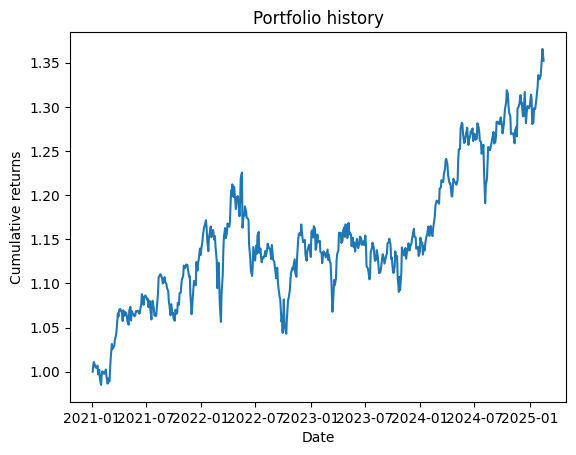

In [11]:
my_portfolio = optimal_portfolio(0.13, verbose=True)

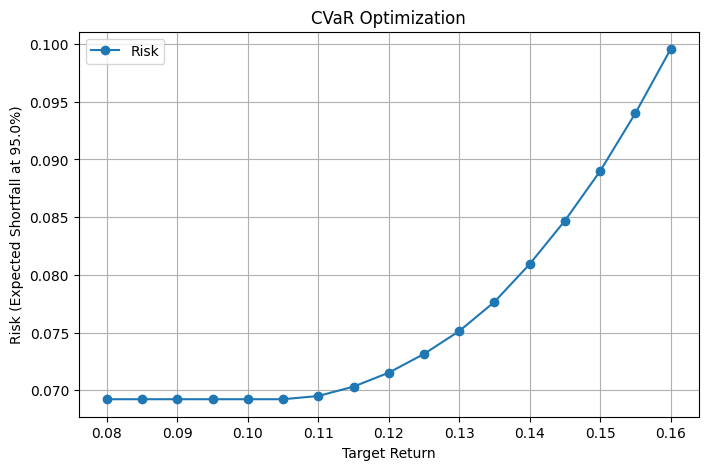

In [12]:
# Plotting
returns_seq = np.arange(0.08, 0.165, 0.005)
risk_seq = [optimal_portfolio(r)["Risk"].value for r in returns_seq]

# Plot both lines
plt.figure(figsize=(8, 5))
plt.plot(returns_seq, risk_seq, label="Risk", linestyle='-', marker='o')

# Labels and Title
plt.xlabel("Target Return")
plt.ylabel(f"Risk (Expected Shortfall at {np.round(100*alpha)}%)")
plt.title("CVaR Optimization")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

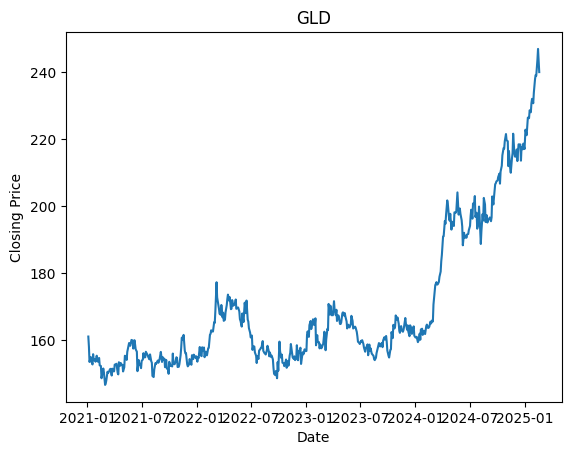

In [13]:
ticker = "GLD"
plt.plot(data[ticker])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(ticker)
plt.show()

Here is some code to calculate the `risk aversion` parameter.

```python
def estimate_risk_aversion():
    """
    Estimate the Black-Litterman risk aversion coefficient (lambda)
    based on market conditions.
    
    Uses:
    - VIX (volatility index)
    - 10-year Treasury Yield (^TNX)
    - S&P 500 drawdown (SPY)

    Returns:
        float: Estimated risk aversion coefficient (lambda)
    """
    
    # Fetch market data
    vix = yf.Ticker("^VIX").history(period="1d")["Close"].iloc[-1]  # Market volatility
    tnx = yf.Ticker("^TNX").history(period="1d")["Close"].iloc[-1] / 100  # Convert from % to decimal
    spy = yf.Ticker("SPY").history(period="6mo")["Close"]  # S&P 500 ETF
    
    # Compute max drawdown over the last 6 months
    max_price = spy.max()
    current_price = spy.iloc[-1]
    drawdown = (max_price - current_price) / max_price  # Drawdown as a fraction
    
    # Baseline risk aversion
    lambda_base = 3.5  # Normal market
    
    # Adjust for VIX (higher VIX → higher lambda)
    if vix < 15:  # Low volatility
        lambda_vix = 3.0
    elif 15 <= vix < 25:  # Normal volatility
        lambda_vix = 3.5
    elif 25 <= vix < 35:  # High volatility
        lambda_vix = 4.5
    else:  # Very high volatility (panic)
        lambda_vix = 5.5
    
    # Adjust for interest rates (higher rates → higher lambda)
    if tnx < 0.02:  # Very low rates
        lambda_tnx = 3.0
    elif 0.02 <= tnx < 0.04:  # Moderate rates
        lambda_tnx = 3.5
    else:  # High rates
        lambda_tnx = 4.5
    
    # Adjust for drawdown (larger drawdown → higher lambda)
    if drawdown < 0.05:  # No major downturn
        lambda_dd = 3.0
    elif 0.05 <= drawdown < 0.10:  # Mild downturn
        lambda_dd = 4.0
    elif 0.10 <= drawdown < 0.20:  # Market correction
        lambda_dd = 5.0
    else:  # Bear market
        lambda_dd = 6.0

    # Weighted average of the different risk aversion factors
    lambda_final = np.mean([lambda_base, lambda_vix, lambda_tnx, lambda_dd])

    print(f"Estimated risk aversion coefficient (lambda): {lambda_final:.2f}")
    return lambda_final

# Run the function to estimate lambda dynamically
lambda_dynamic = estimate_risk_aversion()
```
